Last updated: Jul 06 2015

# Climate data exploration: a journey through Pandas

Welcome to a demo of Python's data analysis package called `Pandas`. Our goal is to learn about Data Analysis and transformation using Pandas while exploring datasets used to analyze climate change. 

## The story

The global goal of this demo is to provide the tools to be able to try and reproduce some of the analysis done in the IPCC global climate reports published in the last decade (see for example https://www.ipcc.ch/pdf/assessment-report/ar5/syr/SYR_AR5_FINAL_full.pdf). 

We are first going to load a few public datasets containing information about global temperature, global and local sea level infomation, and global concentration of greenhouse gases like CO2, to see if there are correlations and how the trends are to evolve, assuming no fundamental change in the system. For all these datasets, we will download them, visualize them, clean them, search through them, merge them, resample them, transform them and summarize them.

In the process, we will learn about:
    1. Loading data
    2. Pandas datastructures
    3. Cleaning and formatting data
    4. Basic visualization
    5. Accessing data
    6. Working with dates and times
    7. Transforming datasets
    8. Statistical analysis
    9. Data agregation and summarization
    10. Correlations and regressions
    11. Predictions from auto regression models

## Some initial setup

In [7]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from pandas import set_option
set_option("display.max_rows", 16)

LARGE_FIGSIZE = (12, 8)

/Users/surajjoshi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
# Change this cell to the demo location on YOUR machine
%cd ~/pandas_tutorial/demos/climate_timeseries/
%ls

/Users/surajjoshi/pandas_tutorial/demos/climate_timeseries
climate_timeseries.ipynb  data/


## 1. Loading data

More details, see http://pandas.pydata.org/pandas-docs/stable/io.html

To find all reading functions in pandas, ask ipython's tab completion:

In [9]:
#pd.read_<TAB>

In [10]:
pd.read_table?

### From a local text file

Let's first load some temperature data which covers all lattitudes. Since read_table is supposed to do the job for a text file, let's just try it:

In [11]:
filename = "data/temperatures/annual.land_ocean.90S.90N.df_1901-2000mean.dat"
full_globe_temp = pd.read_table(filename)
full_globe_temp

,1880 -0.1591
0,1881 -0.0789
1,1882 -0.1313
2,1883 -0.1675
3,1884 -0.2485
4,1885 -0.2042
5,1886 -0.1695
6,1887 -0.2505
7,1888 -0.1605
...,...
122,2003 0.5818


There is only 1 column! Let's try again stating that values are separated by any number of spaces:

In [12]:
full_globe_temp = pd.read_table(filename, sep="\s+")
full_globe_temp

,1880,-0.1591
0,1881,-0.0789
1,1882,-0.1313
2,1883,-0.1675
3,1884,-0.2485
4,1885,-0.2042
5,1886,-0.1695
6,1887,-0.2505
7,1888,-0.1605
...,...,...
122,2003,0.5818


There are columns but the column names are 1880 and -0.1591!

In [13]:
full_globe_temp = pd.read_table(filename, sep="\s+", names=["year", "mean temp"])
full_globe_temp

,year,mean temp
0,1880,-0.1591
1,1881,-0.0789
2,1882,-0.1313
3,1883,-0.1675
4,1884,-0.2485
5,1885,-0.2042
6,1886,-0.1695
7,1887,-0.2505
...,...,...
123,2003,0.5818



Since we only have 2 columns, one of which would be nicer to access the data (the year of the record), let's try using the `index_col` option:

In [14]:
full_globe_temp = pd.read_table(filename, sep="\s+", names=["year", "mean temp"], 
                                index_col=0)
full_globe_temp

,mean temp
year,
1880,-0.1591
1881,-0.0789
1882,-0.1313
1883,-0.1675
1884,-0.2485
1885,-0.2042
1886,-0.1695
1887,-0.2505
...,...


Last step: the index is made of dates. Let's make that explicit:

In [15]:
full_globe_temp = pd.read_table(filename, sep="\s+", names=["year", "mean temp"], 
                                index_col=0, parse_dates=True)
full_globe_temp

,mean temp
year,
1880-01-01 00:00:00,-0.1591
1881-01-01 00:00:00,-0.0789
1882-01-01 00:00:00,-0.1313
1883-01-01 00:00:00,-0.1675
1884-01-01 00:00:00,-0.2485
1885-01-01 00:00:00,-0.2042
1886-01-01 00:00:00,-0.1695
1887-01-01 00:00:00,-0.2505
...,...


### From a chunked file

Since every dataset can contain mistakes, let's load a different file with temperature data. NASA's GISS dataset is written in chunks: look at it in `data/temperatures/GLB.Ts+dSST.txt`

In [29]:
giss_temp = pd.read_table("data/temperatures/GLB.Ts+dSST.txt", sep="\s+", skiprows=7,
                          skip_footer=11, engine="python")
giss_temp

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Year.1
0,1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-22,***,****,-23,-18,-18,1880
1,1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-14,-14,-17,-3,-15,-23,1881
2,1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-17,-16,-4,-15,-23,-20,1882
3,1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-20,-21,-38,-18,-8,-22,1883
4,1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-28,-28,-18,-33,-31,-28,1884
5,1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0,-26,-28,-37,-30,-31,-15,1885
6,1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18,-25,-24,-26,-26,-21,-21,1886
7,1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40,-32,-30,-40,-29,-24,-28,1887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2009,56,48,49,57,59,62,66,61,64,58,72,58,59,59,52,55,63,65,2009


**QUIZ:** What happens if you remove the `skiprows`? `skipfooter`? `engine`?

**EXERCISE:** Load some readings of CO2 concentrations in the atmosphere from the `data/greenhouse_gaz/co2_mm_global.txt` data file.

In [20]:
filename = "data/greenhouse_gaz/co2_mm_global.txt"
globe_co2 = pd.read_table(filename, sep='\s+', parse_dates=[[0,1]])
globe_co2


,year_month,decimal,average,trend
0,1980-01-01,1980.042,338.45,337.82
1,1980-02-01,1980.125,339.17,338.12
2,1980-03-01,1980.208,339.49,338.14
3,1980-04-01,1980.292,339.87,338.25
4,1980-05-01,1980.375,340.30,338.78
5,1980-06-01,1980.458,339.86,339.08
6,1980-07-01,1980.542,338.32,339.17
7,1980-08-01,1980.625,337.11,339.37
...,...,...,...,...
416,2014-09-01,2014.708,394.90,397.61


### From a remote text file

So far, we have only loaded temperature datasets. Climate change also affects the sea levels on the globe. Let's load some datasets with the sea levels. The university of colorado posts updated timeseries for mean sea level globably, per 
hemisphere, or even per ocean, sea, ... Let's download the global one, and the ones for the northern and southern hemisphere.

That will also illustrate that to load text files that are online, there is no more work than replacing the filepath by a URL n `read_table`:

In [21]:
# Local backup: data/sea_levels/sl_nh.txt
northern_sea_level = pd.read_table("http://sealevel.colorado.edu/files/current/sl_nh.txt", 
                                   sep="\s+")
northern_sea_level

,year,msl_ib(mm),#version_2016rel2
0,1992.9323,13.717,NaN
1,1992.9595,1.328,NaN
2,1992.9866,-13.375,NaN
3,1993.0138,-24.723,NaN
4,1993.0409,-29.231,NaN
5,1993.0681,-32.538,NaN
6,1993.0952,-35.588,NaN
7,1993.1223,-26.579,NaN
...,...,...,...
846,2015.9539,69.691,NaN


In [22]:
# Local backup: data/sea_levels/sl_sh.txt
southern_sea_level = pd.read_table("http://sealevel.colorado.edu/files/current/sl_sh.txt", 
                                   sep="\s+")
southern_sea_level

,year,msl_ib(mm),#version_2016rel2
0,1992.9323,2.517,NaN
1,1992.9595,-7.645,NaN
2,1992.9866,-2.267,NaN
3,1993.0138,0.855,NaN
4,1993.0409,-2.020,NaN
5,1993.0681,-0.398,NaN
6,1993.0952,4.102,NaN
7,1993.1223,6.787,NaN
...,...,...,...
846,2015.9539,77.618,NaN


In [23]:
# The 2015 version of the global dataset:
# Local backup: data/sea_levels/sl_ns_global.txt
url = "http://sealevel.colorado.edu/files/2015_rel2/sl_ns_global.txt"
global_sea_level = pd.read_table(url, sep="\s+")
global_sea_level

,year,msl_ib_ns(mm),#version_2015_rel2
0,1992.9595,-5.818,NaN
1,1992.9866,-7.525,NaN
2,1993.0138,-9.215,NaN
3,1993.0409,-11.796,NaN
4,1993.0681,-11.291,NaN
5,1993.0952,-9.569,NaN
6,1993.1223,-3.714,NaN
7,1993.1495,-2.471,NaN
...,...,...,...
772,2014.9494,70.723,NaN


There are clearly lots of cleanup to be done on these datasets. See below...

### From a local or remote HTML file

To be able to grab more local data about mean sea levels, we can download and extract data about mean sea level stations around the world from the PSMSL (http://www.psmsl.org/). Again to download and parse all tables in a webpage, just give `read_html` the URL to parse:

In [26]:
# Needs `lxml`, `beautifulSoup4` and `html5lib` python packages
# Local backup in data/sea_levels/Obtaining Tide Gauge Data.html
table_list = pd.read_html("http://www.psmsl.org/data/obtaining/")

In [27]:
# there is 1 table on that page which contains metadata about the stations where 
# sea levels are recorded
local_sea_level_stations = table_list[0]
local_sea_level_stations

,Station Name,ID,Lat.,Lon.,GLOSS ID,Country,Date,Coastline,Station
0,HELIGMAN,231,60.200,19.300,NaN,ALA,01/01/1980,60,251
1,KOBBAKLINTAR,63,60.033,19.883,NaN,ALA,01/01/1980,60,261
2,LEMSTROM,84,60.100,20.017,NaN,ALA,01/01/1980,60,271
3,FOGLO / DEGERBY,249,60.032,20.385,NaN,ALA,06/10/2015,60,281
4,PAGO PAGO,539,-14.280,-170.690,144,ASM,08/03/2016,745,1
5,BAHIA ESPERANZA,988,-63.300,-56.917,185,ATA,11/05/1999,999,1
6,ARGENTINE ISLANDS,913,-65.246,-64.257,188,ATA,21/05/2015,999,3
7,PUERTO SOBERANIA,1603,-62.483,-59.633,189,ATA,30/09/2004,999,5
...,...,...,...,...,...,...,...,...,...
1458,DANANG,1475,16.100,108.217,NaN,VNM,17/11/2015,605,51


That table can be used to search for a station in a region of the world we choose, extract an ID for it and download the corresponding time series with the URL http://www.psmsl.org/data/obtaining/met.monthly.data/< ID >.metdata

## 2. Pandas DataStructures

For more details, see http://pandas.pydata.org/pandas-docs/stable/dsintro.html

Now that we have used `read_**` functions to load datasets, we need to understand better what kind of objects we got from them to learn to work with them.

### DataFrame, the pandas 2D structure

In [30]:
# Type of the object?
type(giss_temp)

pandas.core.frame.DataFrame

In [31]:
# Internal nature of the object
print(giss_temp.shape)
print(giss_temp.dtypes)

(143, 20)
Year      object
Jan       object
Feb       object
Mar       object
Apr       object
May       object
Jun       object
Jul       object
           ...  
Dec       object
J-D       object
D-N       object
DJF       object
MAM       object
JJA       object
SON       object
Year.1    object
dtype: object


Descriptors for the vertical axis (axis=0)

In [32]:
giss_temp.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            133, 134, 135, 136, 137, 138, 139, 140, 141, 142],
           dtype='int64', length=143)

Descriptors for the horizontal axis (axis=1)

In [33]:
giss_temp.columns

Index([u'Year', u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', u'Aug',
       u'Sep', u'Oct', u'Nov', u'Dec', u'J-D', u'D-N', u'DJF', u'MAM', u'JJA',
       u'SON', u'Year.1'],
      dtype='object')

A lot of information at once including memory usage:

In [34]:
giss_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 20 columns):
Year      143 non-null object
Jan       143 non-null object
Feb       143 non-null object
Mar       143 non-null object
Apr       143 non-null object
May       143 non-null object
Jun       143 non-null object
Jul       143 non-null object
Aug       143 non-null object
Sep       143 non-null object
Oct       143 non-null object
Nov       143 non-null object
Dec       143 non-null object
J-D       143 non-null object
D-N       143 non-null object
DJF       143 non-null object
MAM       143 non-null object
JJA       143 non-null object
SON       143 non-null object
Year.1    143 non-null object
dtypes: object(20)
memory usage: 23.5+ KB


### Series, the pandas 1D structure

A series can be constructed with the `pd.Series` constructor (passing a list or array of values) or from a `DataFrame`, by extracting one of its columns.

In [35]:
# Do we already have a series for the full_globe_temp?
type(full_globe_temp)

pandas.core.frame.DataFrame

In [36]:
# Since there is only one column of values, we can make this a Series without 
# loosing information:
full_globe_temp = full_globe_temp["mean temp"]

Core attributes/information:

In [37]:
print(type(full_globe_temp))
print(full_globe_temp.dtype)
print(full_globe_temp.shape)
print(full_globe_temp.nbytes)

<class 'pandas.core.series.Series'>
float64
(131,)
1048


Probably the most important attribute of a `Series` or `DataFrame` is its `index` since we will use that to, well, index into the structures to access te information:

In [38]:
full_globe_temp.index

DatetimeIndex(['1880-01-01', '1881-01-01', '1882-01-01', '1883-01-01',
               '1884-01-01', '1885-01-01', '1886-01-01', '1887-01-01',
               '1888-01-01', '1889-01-01',
               ...
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01'],
              dtype='datetime64[ns]', name=u'year', length=131, freq=None)

### NumPy arrays as backend of Pandas

It is always possible to fall back to a good old NumPy array to pass on to scientific libraries that need them: SciPy, scikit-learn, ...

In [39]:
full_globe_temp.values

array([ -1.59100000e-01,  -7.89000000e-02,  -1.31300000e-01,
        -1.67500000e-01,  -2.48500000e-01,  -2.04200000e-01,
        -1.69500000e-01,  -2.50500000e-01,  -1.60500000e-01,
        -1.10300000e-01,  -3.01400000e-01,  -2.52700000e-01,
        -2.92600000e-01,  -3.27400000e-01,  -2.88000000e-01,
        -2.14600000e-01,  -1.00900000e-01,  -1.29400000e-01,
        -2.51700000e-01,  -1.35600000e-01,  -1.12500000e-01,
        -1.69300000e-01,  -2.25500000e-01,  -3.44200000e-01,
        -3.79900000e-01,  -2.58300000e-01,  -2.06000000e-01,
        -3.72600000e-01,  -3.92200000e-01,  -4.04100000e-01,
        -3.86000000e-01,  -4.14400000e-01,  -3.42200000e-01,
        -3.19600000e-01,  -1.59900000e-01,  -8.10000000e-02,
        -2.80300000e-01,  -3.22700000e-01,  -2.10600000e-01,
        -2.18600000e-01,  -2.02500000e-01,  -1.39000000e-01,
        -2.22200000e-01,  -2.06300000e-01,  -1.84300000e-01,
        -1.26000000e-01,  -1.92000000e-02,  -1.00700000e-01,
        -9.35000000e-02,

In [40]:
type(full_globe_temp.values)

numpy.ndarray

### Creating new DataFrames manually

`DataFrame`s can also be created manually, by grouping several Series together. Let's make a new frame from the 3 sea level datasets we downloaded above. They will be displayed along the same index. Wait, does that makes sense to do that?

In [41]:
# Are they aligned?
southern_sea_level.year == northern_sea_level.year

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
       ... 
846    True
847    True
848    True
849    True
850    True
851    True
852    True
853    True
Name: year, dtype: bool

In [42]:
# So, are they aligned?
np.all(southern_sea_level.year == northern_sea_level.year)

True

So the northern hemisphere and southern hemisphere datasets are aligned. What about the global one?

In [43]:
len(global_sea_level.year) == len(northern_sea_level.year)

False

For now, let's just build a DataFrame with the 2 hemisphere datasets then. We will come back to add the global one later...

In [ ]:
mean_sea_level = pd.DataFrame({"northern_hem": northern_sea_level["msl_ib(mm)"], 
                               "southern_hem": southern_sea_level["msl_ib(mm)"], 
                               "date": northern_sea_level.year})
mean_sea_level

Note: there are other ways to create DataFrames manually, for example from a 2D numpy array.

There is still the date in a regular column and a numerical index that is not that meaningful. We can specify the `index` of a `DataFrame` at creation. Let's try:

In [ ]:
mean_sea_level = pd.DataFrame({"northern_hem": northern_sea_level["msl_ib(mm)"], 
                               "southern_hem": southern_sea_level["msl_ib(mm)"]},
                               index = northern_sea_level.year)
mean_sea_level

Now the fact that it is failing show that Pandas does auto-alignment of values: for each value of the index, it searches for a value in each Series that maps the same value. Since these series have a dumb numerical index, no values are found. 

Since we know that the order of the values match the index we chose, we can replace the Series by their values only at creation of the DataFrame:

In [52]:
mean_sea_level = pd.DataFrame({"northern_hem": northern_sea_level["msl_ib(mm)"].values, 
                               "southern_hem": southern_sea_level["msl_ib(mm)"].values},
                               index = northern_sea_level.year)
mean_sea_level

,northern_hem,southern_hem
year,,
1992.9323,13.717,2.517
1992.9595,1.328,-7.645
1992.9866,-13.375,-2.267
1993.0138,-24.723,0.855
1993.0409,-29.231,-2.020
1993.0681,-32.538,-0.398
1993.0952,-35.588,4.102
1993.1223,-26.579,6.787
...,...,...


## 3. Cleaning and formatting data

The datasets that we obtain straight from the reading functions are pretty raw. A lot of pre-processing can be done during data read but we haven't used all the power of the reading functions. Let's learn to do a lot of cleaning and formatting of the data.

The GISS temperature dataset has a lot of issues too: useless numerical index, redundant columns, useless rows, placeholder (`****`) for missing values, and wrong type for the columns. Let's fix all this:

### Renaming columns

In [53]:
# The columns of the local_sea_level_stations aren't clean: they contain spaces and dots.
local_sea_level_stations.columns

Index([u'Station Name', u'ID', u'Lat.', u'Lon.', u'GLOSS ID  ', u'Country  ',
       u'Date', u'Coastline  ', u'Station  '],
      dtype='object')

In [54]:
# Let's clean them up a bit:
local_sea_level_stations.columns = [name.strip().replace(".", "") 
                                    for name in local_sea_level_stations.columns]
local_sea_level_stations.columns

Index([u'Station Name', u'ID', u'Lat', u'Lon', u'GLOSS ID', u'Country',
       u'Date', u'Coastline', u'Station'],
      dtype='object')

We can also rename an index by setting its name. For example, the index of the `mean_sea_level` dataFrame could be called `date` since it contains more than just the year:

In [55]:
mean_sea_level.index.name = "date"
mean_sea_level

,northern_hem,southern_hem
date,,
1992.9323,13.717,2.517
1992.9595,1.328,-7.645
1992.9866,-13.375,-2.267
1993.0138,-24.723,0.855
1993.0409,-29.231,-2.020
1993.0681,-32.538,-0.398
1993.0952,-35.588,4.102
1993.1223,-26.579,6.787
...,...,...


### Setting missing values

In the full globe dataset, -999.00 was used to indicate that there was no value for that year. Let's search for all these values and replace them with the missing value that Pandas understand: `np.nan` 

In [ ]:
full_globe_temp == -999.000

In [ ]:
full_globe_temp[full_globe_temp == -999.000] = np.nan
full_globe_temp.tail()

### Choosing what is the index

In [44]:
# We didn't set a column number of the index of giss_temp, we can do that afterwards:
giss_temp = giss_temp.set_index("Year")
giss_temp.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Year.1
Year,,,,,,,,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-22,***,****,-23,-18,-18,1880
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-14,-14,-17,-3,-15,-23,1881
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-17,-16,-4,-15,-23,-20,1882
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-20,-21,-38,-18,-8,-22,1883
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-28,-28,-18,-33,-31,-28,1884


### Dropping rows and columns

In [45]:
# 1 column is redundant with the index: 
giss_temp.columns

Index([u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', u'Aug', u'Sep',
       u'Oct', u'Nov', u'Dec', u'J-D', u'D-N', u'DJF', u'MAM', u'JJA', u'SON',
       u'Year.1'],
      dtype='object')

In [46]:
# Let's drop it:
giss_temp = giss_temp.drop("Year.1", axis=1)
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-22,***,****,-23,-18,-18
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-14,-14,-17,-3,-15,-23
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-17,-16,-4,-15,-23,-20
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-20,-21,-38,-18,-8,-22
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-28,-28,-18,-33,-31,-28
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0,-26,-28,-37,-30,-31,-15
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18,-25,-24,-26,-26,-21,-21
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40,-32,-30,-40,-29,-24,-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [47]:
# We can also just select the columns we want to keep:
giss_temp = giss_temp[[u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', 
                       u'Aug', u'Sep', u'Oct', u'Nov', u'Dec']]
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40
...,...,...,...,...,...,...,...,...,...,...,...,...


In [48]:
# Let's remove all these extra column names (Year  Jan ...). They all correspond to the index "Year"
giss_temp = giss_temp.drop("Year")
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40
...,...,...,...,...,...,...,...,...,...,...,...,...


Let's also set `****` to a real missing value (`np.nan`). We can often do it using a boolean mask, but that may trigger pandas warning. Another way to assign based on a boolean condition is to use the `where` method:

In [49]:
#giss_temp[giss_temp == "****"] = np.nan
giss_temp = giss_temp.where(giss_temp != "****", np.nan)

In [50]:
giss_temp.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,45,44,57,60,47,54,70,69,52,60,50,48
2012,38,43,52,62,71,59,50,56,68,73,69,46
2013,62,52,60,48,56,61,53,61,73,61,75,61
2014,68,44,71,72,79,62,50,74,81,78,64,74
2015,75,80,84,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding columns

While building the `mean_sea_level` dataFrame earlier, we didn't include the values from `global_sea_level` since the years were not aligned. Adding a column to a dataframe is as easy as adding an entry to a dictionary. So let's try:

In [56]:
mean_sea_level["mean_global"] = global_sea_level["msl_ib_ns(mm)"]
mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992.9323,13.717,2.517,NaN
1992.9595,1.328,-7.645,NaN
1992.9866,-13.375,-2.267,NaN
1993.0138,-24.723,0.855,NaN
1993.0409,-29.231,-2.020,NaN
1993.0681,-32.538,-0.398,NaN
1993.0952,-35.588,4.102,NaN
1993.1223,-26.579,6.787,NaN
...,...,...,...


The column is full of NaNs again because the auto-alignment feature of Pandas is searching for the index values like `1992.9323` in the index of `global_sea_level["msl_ib_ns(mm)"]` series and not finding them. Let's set its index to these years so that that auto-alignment can work for us and figure out which values we have and not:

In [57]:
global_sea_level = global_sea_level.set_index("year")
global_sea_level["msl_ib_ns(mm)"]

year
1992.9595    -5.818
1992.9866    -7.525
1993.0138    -9.215
1993.0409   -11.796
1993.0681   -11.291
1993.0952    -9.569
1993.1223    -3.714
1993.1495    -2.471
              ...  
2014.9494    70.723
2014.9766    70.522
2015.0037    66.662
2015.0309    64.804
2015.0580    62.115
2015.0852    68.589
2015.1123    69.745
2015.1395    75.007
Name: msl_ib_ns(mm), dtype: float64

In [58]:
mean_sea_level["mean_global"] = global_sea_level["msl_ib_ns(mm)"]
mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992.9323,13.717,2.517,NaN
1992.9595,1.328,-7.645,-5.818
1992.9866,-13.375,-2.267,-7.525
1993.0138,-24.723,0.855,-9.215
1993.0409,-29.231,-2.020,-11.796
1993.0681,-32.538,-0.398,-11.291
1993.0952,-35.588,4.102,-9.569
1993.1223,-26.579,6.787,-3.714
...,...,...,...


**EXERCISE:** Create a new series containing the average of the 2 hemispheres minus the global value to see if that is close to 0. Work inside the mean_sea_level dataframe first. Then try with the original Series to see what happens with data alignment while doing computations.

In [61]:
(mean_sea_level.northern_hem+mean_sea_level.southern_hem)/2-global_sea_level['msl_ib_ns(mn)']

KeyError: 'msl_ib_ns(mn)'

### Changing dtype of series

Now that the sea levels are looking pretty good, let's got back to the GISS temperature dataset. Because of the labels (strings) found in the middle of the timeseries, every column only assumed to contain strings (didn't convert them to floating point values):

In [62]:
giss_temp.dtypes

Jan    object
Feb    object
Mar    object
Apr    object
May    object
Jun    object
Jul    object
Aug    object
Sep    object
Oct    object
Nov    object
Dec    object
dtype: object

That can be changed after the fact (and after the cleanup) with the `astype` method of a `Series`:

In [63]:
giss_temp["Jan"].astype("float32")

Year
1880   -34
1881   -13
1882     3
1883   -38
1884   -20
1885   -57
1886   -37
1887   -60
        ..
2008    22
2009    56
2010    66
2011    45
2012    38
2013    62
2014    68
2015    75
Name: Jan, dtype: float32

In [64]:
for col in giss_temp.columns:
    giss_temp.loc[:, col] = giss_temp[col].astype(np.float32)

An index has a `dtype` just like any Series and that can be changed after the fact too.

In [65]:
giss_temp.index.dtype

dtype('O')

For now, let's change it to an integer so that values can at least be compared properly. We will learn below to change it to a datetime object.

In [66]:
giss_temp.index = giss_temp.index.astype(np.int32)

### Removing missing values

Removing missing values - once they have been converted to `np.nan` - is very easy. Entries that contain missing values can be removed (dropped), or filled with many strategies.

In [67]:
full_globe_temp

year
1880-01-01 00:00:00     -0.1591
1881-01-01 00:00:00     -0.0789
1882-01-01 00:00:00     -0.1313
1883-01-01 00:00:00     -0.1675
1884-01-01 00:00:00     -0.2485
1885-01-01 00:00:00     -0.2042
1886-01-01 00:00:00     -0.1695
1887-01-01 00:00:00     -0.2505
                         ...   
2003-01-01               0.5818
2004-01-01               0.5416
2005-01-01               0.6154
2006-01-01               0.5601
2007-01-01               0.5472
2008-01-01               0.4804
2009-01-01               0.5551
2010-01-01            -999.0000
Name: mean temp, dtype: float64

In [74]:
full_globe_temp.dropna()

year
1880-01-01 00:00:00     -0.1591
1881-01-01 00:00:00     -0.0789
1882-01-01 00:00:00     -0.1313
1883-01-01 00:00:00     -0.1675
1884-01-01 00:00:00     -0.2485
1885-01-01 00:00:00     -0.2042
1886-01-01 00:00:00     -0.1695
1887-01-01 00:00:00     -0.2505
                         ...   
2003-01-01               0.5818
2004-01-01               0.5416
2005-01-01               0.6154
2006-01-01               0.5601
2007-01-01               0.5472
2008-01-01               0.4804
2009-01-01               0.5551
2010-01-01            -999.0000
Name: mean temp, dtype: float64

In [75]:
# This will remove any year that has a missing value. Use how='all' to keep partial years
giss_temp.dropna(how="any").tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,66,75,87,82,71,60,56,59,55,65,74,44
2011,45,44,57,60,47,54,70,69,52,60,50,48
2012,38,43,52,62,71,59,50,56,68,73,69,46
2013,62,52,60,48,56,61,53,61,73,61,75,61
2014,68,44,71,72,79,62,50,74,81,78,64,74


In [76]:
giss_temp.fillna(value=0).tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,45,44,57,60,47,54,70,69,52,60,50,48
2012,38,43,52,62,71,59,50,56,68,73,69,46
2013,62,52,60,48,56,61,53,61,73,61,75,61
2014,68,44,71,72,79,62,50,74,81,78,64,74
2015,75,80,84,71,0,0,0,0,0,0,0,0


In [77]:
# This fills them with the previous year. See also temp3.interpolate
giss_temp.fillna(method="ffill").tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,45,44,57,60,47,54,70,69,52,60,50,48
2012,38,43,52,62,71,59,50,56,68,73,69,46
2013,62,52,60,48,56,61,53,61,73,61,75,61
2014,68,44,71,72,79,62,50,74,81,78,64,74
2015,75,80,84,71,79,62,50,74,81,78,64,74


Let's also mention the `.interpolate` method on a `Series`:

In [78]:
giss_temp.Aug.interpolate().tail()

Year
2011    69
2012    56
2013    61
2014    74
2015    74
Name: Aug, dtype: float32

For now, we will leave the missing values in all our datasets, because it wouldn't be meaningful to fill them.

**EXERCISE:** Go back to the reading functions, and learn more about other options that could have allowed us to fold some of these pre-processing steps into the data loading.

## 4. Basic visualization

Now they have been formatted, visualizing your datasets is the next logical step and is trivial with Pandas. The first thing to try is to invoke the `.plot` to generate a basic visualization (uses matplotlib under the covers).

### Line plots

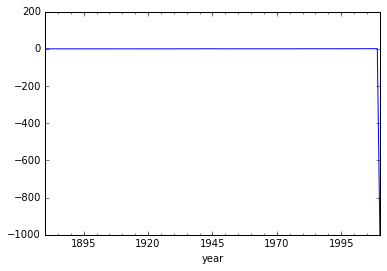

In [79]:
full_globe_temp.plot()

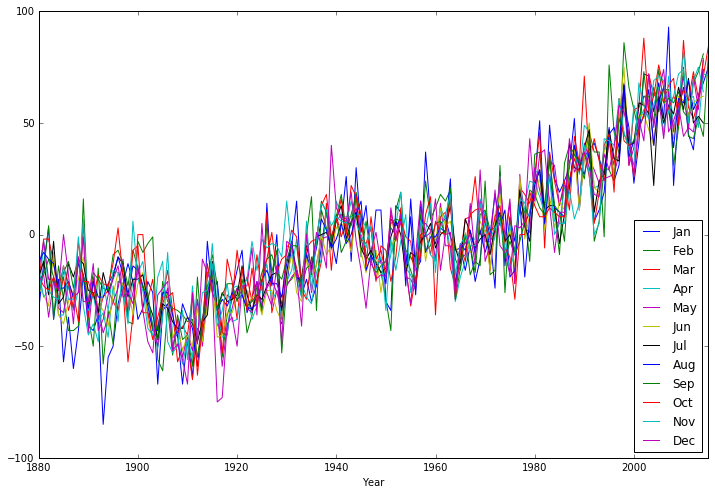

In [80]:
giss_temp.plot(figsize=LARGE_FIGSIZE)

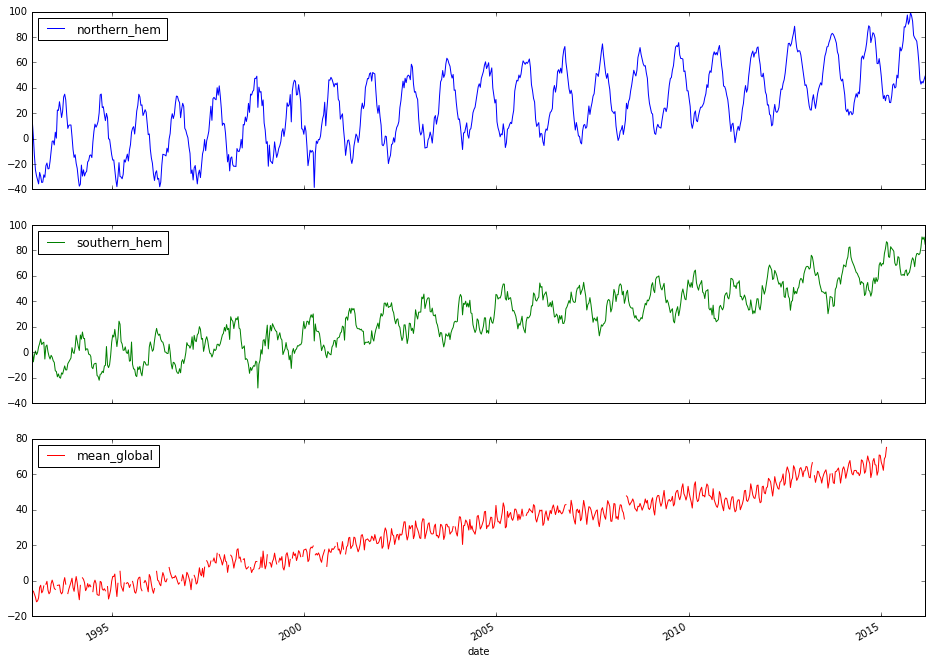

In [81]:
mean_sea_level.plot(subplots=True, figsize=(16, 12));

### Showing distributions information

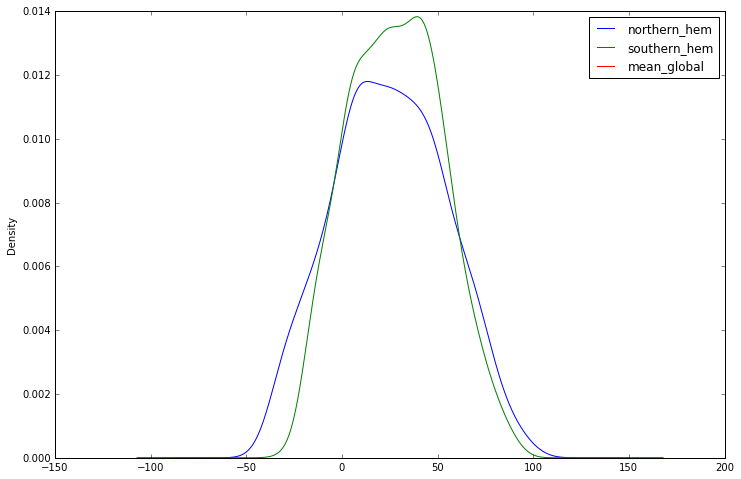

In [82]:
# Distributions of mean sean level globally and per hemisphere?
mean_sea_level.plot(kind="kde", figsize=(12, 8))

**QUIZ:** How to list the possible kinds of plots that the plot method can allow?

/Users/surajjoshi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


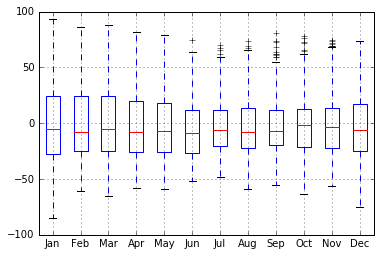

In [83]:
# Distributions of temperature in each month since 1880
giss_temp.boxplot();

### Correlations

There are more plot options inside `pandas.tools.plotting`:

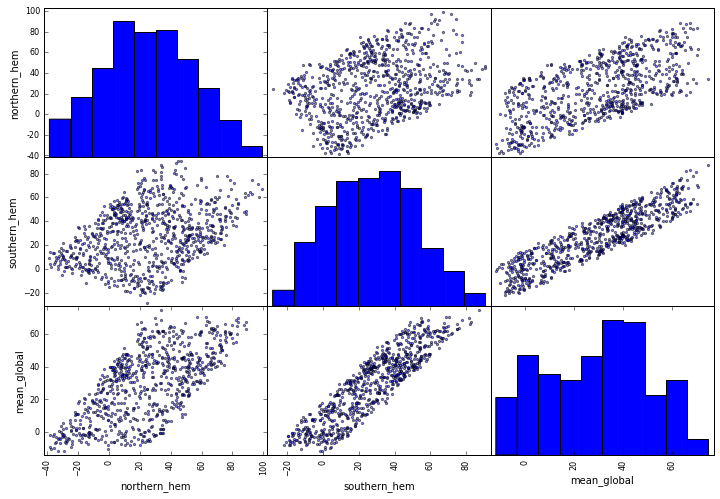

In [84]:
# Is there correlations between the northern and southern sea level timeseries we loaded?
from pandas.tools.plotting import scatter_matrix
scatter_matrix(mean_sea_level, figsize=LARGE_FIGSIZE);

We will confirm the correlations we think we see further down...

**EXERCISE:** Refer to `exercises/aapl_adj_close_plot/aapl_adj_close_plot.ipynb`

## 5. Accessing data

The general philosophy for accessing values inside a Pandas datastructure is that, unlike a numpy array that only allows to index using integers a Series allows to index with the values inside the index. That makes the code more readable.

### In a series

In [85]:
full_globe_temp

year
1880-01-01 00:00:00     -0.1591
1881-01-01 00:00:00     -0.0789
1882-01-01 00:00:00     -0.1313
1883-01-01 00:00:00     -0.1675
1884-01-01 00:00:00     -0.2485
1885-01-01 00:00:00     -0.2042
1886-01-01 00:00:00     -0.1695
1887-01-01 00:00:00     -0.2505
                         ...   
2003-01-01               0.5818
2004-01-01               0.5416
2005-01-01               0.6154
2006-01-01               0.5601
2007-01-01               0.5472
2008-01-01               0.4804
2009-01-01               0.5551
2010-01-01            -999.0000
Name: mean temp, dtype: float64

In [86]:
# By default [] on a series accesses values using the index, not the location in the series
# print(temp1[0])  # This would to fail!!

In [87]:
# This index is non-trivial though (will talk more about these datetime objects further down):
full_globe_temp.index.dtype

dtype('<M8[ns]')

In [88]:
first_date = full_globe_temp.index[0]
first_date == pd.Timestamp('1880')

True

In [89]:
# By default [] on a series accesses values using the index, not the location in the series
print(full_globe_temp[pd.Timestamp('1880')])
# print(temp1[0])  # This would fail!!

-0.1591


In [90]:
# Another more explicit way to do the same thing is to use loc
print(full_globe_temp.loc[pd.Timestamp('1990')])
print(full_globe_temp.iloc[0], full_globe_temp.iloc[-1])

0.3861
(-0.15909999999999999, -999.0)


In [91]:
# Year of the last record?
full_globe_temp.index[-1]

Timestamp('2010-01-01 00:00:00')

In [92]:
# New records can be added:
full_globe_temp[pd.Timestamp('2011')] = np.nan

### In a dataframe

In [93]:
# In 2D, same idea, though in a DF [] accesses columns (Series)
giss_temp["Jan"]

Year
1880   -34
1881   -13
1882     3
1883   -38
1884   -20
1885   -57
1886   -37
1887   -60
        ..
2008    22
2009    56
2010    66
2011    45
2012    38
2013    62
2014    68
2015    75
Name: Jan, dtype: float32

In [94]:
# while .loc and .iloc allow to access individual values, slices or masked selections:
print(giss_temp.loc[1979, "Dec"])

43.0


In [95]:
# Slicing can be done with .loc and .iloc
print(giss_temp.loc[1979, "Jan":"Jun"])  # Note that the end point is included unlike NumPy!!!
print(giss_temp.loc[1979, ::2])

Jan    10
Feb   -12
Mar    14
Apr     8
May     1
Jun     9
Name: 1979, dtype: float32
Jan    10
Mar    14
May     1
Jul    -3
Sep    20
Nov    24
Name: 1979, dtype: float32


In [96]:
# Masking can also be used in one or more dimensions. For example, another way to grab every other month for the first year:
mask = [True, False] * 6
print(giss_temp.iloc[0, mask])
print(giss_temp.loc[1880, mask])

Jan   -34
Mar   -22
May   -16
Jul   -19
Sep   -20
Nov   -16
Name: 1880, dtype: float32
Jan   -34
Mar   -22
May   -16
Jul   -19
Sep   -20
Nov   -16
Name: 1880, dtype: float32


In [97]:
# We could also add a new column like a new entry in a dictionary
giss_temp["totals"] = giss_temp.sum(axis=1)
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,totals
Year,,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-260
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-171
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-207
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-239
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-333
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0,-313
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18,-303
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40,-389
...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [98]:
# Let's remove this new column, we will learn to do this differently
giss_temp = giss_temp.drop("totals", axis=1)

More complex queries rely on the same concepts. For example what are the names, and IDs of the sea level stations in the USA?

In [99]:
local_sea_level_stations.columns

Index([u'Station Name', u'ID', u'Lat', u'Lon', u'GLOSS ID', u'Country',
       u'Date', u'Coastline', u'Station'],
      dtype='object')

In [100]:
american_stations = local_sea_level_stations["Country"] == "USA"
local_sea_level_stations.loc[american_stations, ["ID", "Station Name"]]

,ID,Station Name
1267,1372,FRENCH FRIGATE SHOALS
1268,2192,FRENCH FRIGATE SHOALS B
1269,2129,"PORT ALLEN, HANAPEPE BAY, KAUAI ISLAND"
1270,756,"NAWILIWILI BAY, KAUAI ISLAND"
1271,155,HONOLULU
1272,823,MOKUOLOE ISLAND
1273,2273,"LANAI ISLAND, KAUMALAPAU"
1274,521,"KAHULUI HARBOR, MAUI ISLAND"
...,...,...
1437,288,SEAVEY ISLAND


## 6. Working with dates and times

More details at http://pandas.pydata.org/pandas-docs/stable/timeseries.html

Let's work some more with `full_globe_temp`'s index since we saw it is special.

In [ ]:
# Its dtype is NumPy's new 'datetime64[ns]':
full_globe_temp.index.dtype

The advantage of having a real datetime index is that operations can be done efficiently on it. Let's add a flag to signal if the value is before or after the great depression's black Friday:

In [ ]:
black_friday = pd.to_datetime('1929-10-29')
full_globe_temp.index > black_friday

### Timestamps or periods?

In [ ]:
# Convert its index from timestamp to period: it is more meaningfull since it was measured and averaged over the year...
full_globe_temp.index = full_globe_temp.index.to_period()
full_globe_temp

See also `to_timestamp` to conver back to timestamps and its `how` method to specify when inside the range to set the timestamp.

### Resampling

Another thing that can be done is to resample the series, downsample or upsample. Let's see the series converted to 10 year blocks or upscale to a monthly series:

In [ ]:
# Frequencies can be specified as strings: "us", "ms", "S", "T", "H", "D", "B", "W", "M", "A", "3min", "2h20", ...
# More aliases at http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
full_globe_temp.resample("M")

In [ ]:
full_globe_temp.resample("10A", how="mean")

### Generating DatetimeIndex objects

The index for `giss_temp` isn't an instance of datetimes so we may want to generate such `DatetimeIndex` objects. This can be done with `date_range` and `period_range`:

In [ ]:
# Can specify a start date and a number of values desired. By default it will assume an interval of 1 day:
pd.date_range('1/1/1880', periods=4)

In [ ]:
# Can also specify a start and a stop date, as well as a frequency
pd.date_range('1/1/1880', '1/1/2016', freq="A")

Note that `"A"` by default means the end of the year. Other times in the year can be specified with `"AS"` (start), `"A-JAN"` or `"A-JUN"`. Even more options can be imported from `pandas.tseries.offsets`:

In [ ]:
from pandas.tseries.offsets import YearBegin
pd.date_range('1/1/1880', '1/1/2015', freq=YearBegin())

Actually we will convert that dataset to a 1D dataset, and build a monthly index, so lets build a monthly period index

In [ ]:
giss_temp_index = pd.period_range('1/1/1880', '12/1/2015', freq="M")
giss_temp_index

## 7. Transforming datasets: apply, sort, stack/unstack and transpose

Let's look at our `local_sea_level_stations` dataset some more, to learn more about it and also do some formatting. What is the range of dates and lattitudes we have, the list of countries, the range of variations, ...

In [ ]:
# What about the range of dates?
local_sea_level_stations["Date"].min(), local_sea_level_stations["Date"].max(), local_sea_level_stations["Date"].iloc[-1]

In [ ]:
local_sea_level_stations.dtypes

### Apply: transforming Series

We don't see the range of dates because the dates are of dtype "Object", (usually meaning strings). Let's convert that using `apply`:

In [ ]:
local_sea_level_stations["Date"].apply(pd.to_datetime)

This `apply` method is very powerful and general. We have used it to do something we could have done with `astype`, but any custom function can be provided to `apply`.

In [ ]:
local_sea_level_stations["Date"] = local_sea_level_stations["Date"].apply(pd.to_datetime)

# Now we can really compare the dates, and therefore get a real range:
print(local_sea_level_stations["Date"].min(), local_sea_level_stations["Date"].max())

**EXERCISE:** Use the `apply` method to search through the stations names for a station in New York. What is the ID of the station?

In [ ]:
# Your code here

Now that we know the range of dates, to look at the data, sorting it following the dates is done with `sort`:

In [ ]:
local_sea_level_stations.sort("Date")

Since many stations last updated on the same dates, it is logical to want to sort further, for example, by `Country` at constant date:

In [ ]:
local_sea_level_stations.sort(["Date", "Country"], ascending=False)

### Stack and unstack

Let's look at the GISS dataset differently. Instead of seeing the months along the axis 1, and the years along the axis 0, it would could be good to convert these into an outer and an inner axis along only 1 time dimension.

Stacking and unstacking allows to convert a dataframe into a series and vice-versa:

In [ ]:
giss_temp.unstack?
unstacked = giss_temp.unstack()
unstacked

In [ ]:
# Note the nature of the result:
type(unstacked)

The result is grouped in the wrong order since it sorts first the axis that was unstacked. Another transformation that would help us is transposing...

In [ ]:
giss_temp.transpose()

In [ ]:
giss_temp_series = giss_temp.transpose().unstack()
giss_temp_series.name = "Temp anomaly"
giss_temp_series

### A side note: Multi-indexes

In [ ]:
# Note the nature of the resulting index:
giss_temp_series.index

In [ ]:
# It is an index made of 2 columns. Let's fix the fact that one of them doesn't have a name:
giss_temp_series.index = giss_temp_series.index.set_names(["year", "month"])

In [ ]:
# We can now access deviations by specifying the year and month:
giss_temp_series[1980, "Jan"]

But this new multi-index isn't very good, because is it not viewed as 1 date, just as a tuple of values:

In [ ]:
giss_temp_series.plot(figsize=LARGE_FIGSIZE)

To improve on this, let's reuse an index we generated above with `date_range`:

In [ ]:
giss_temp_series.index = giss_temp_index
giss_temp_series.plot(figsize=LARGE_FIGSIZE)

## 8. Statistical analysis

### Descriptive statistics

Let's go back to the dataframe version of the GISS temperature dataset temporarily to analyze anomalies month per month. Like most functions on a dataframe, stats functions are computed column per column. They also ignore missing values:

In [ ]:
monthly_averages = giss_temp.mean()
monthly_averages

It is possible to apply stats functions across rows instead of columns using the `axis` keyword (just like in NumPy).

In [ ]:
yearly_averages = giss_temp.mean(axis=1)
yearly_averages

`describe` provides many descriptive stats computed at once:

In [ ]:
mean_sea_level.describe()

### Rolling statistics

Let's remove high frequency signal and extract the trend:

In [ ]:
full_globe_temp.plot()
pd.rolling_mean(full_globe_temp, 10).plot(figsize=LARGE_FIGSIZE)

In [ ]:
# To see what all can be done while rolling, 
#pd.rolling_<TAB>

### Describing categorical series

Let's look at our `local_sea_level_stations` dataset some more:

In [ ]:
local_sea_level_stations.describe()

`.describe()` only displays information about continuous `Series`. What about categorical ones?

In [ ]:
local_sea_level_stations.columns

In [ ]:
local_sea_level_stations["Country"]

In [ ]:
local_sea_level_stations["Country"].describe()

In [ ]:
# List of unique values:
local_sea_level_stations["Country"].unique()

In [ ]:
local_sea_level_stations["Country"].value_counts()

In [ ]:
# To save memory, we can convert it to a categorical column:
local_sea_level_stations["Country"] = local_sea_level_stations["Country"].astype("category")

We can also create categorical series from continuous ones with the cut function:

In [ ]:
categorized = pd.cut(full_globe_temp, 3, labels=["L", "M", "H"])
categorized

In [ ]:
# The advantage is that we can use labels and control the order they should be treated in (L < M < H)
categorized.cat.categories

**QUIZ:** How much memory did we save? What if it was categorized but with dtype `object` instead of `category`?

## 9. Data Aggregation/summarization

Now that we have a good grasp on our datasets, Let's transform and analyze them some more to prepare them to compare them. The 2 function(alities)s to learn about here are `groupby` and `pivot_table`.

### GroupBy

Let's explore the sea levels, first splitting into calendar years to compute average sea levels for each year:

In [ ]:
mean_sea_level

In [ ]:
mean_sea_level = mean_sea_level.reset_index()
mean_sea_level

In [ ]:
# Groupby with pandas can be done on a column or by applying a custom function to the index. 
# If we want to group the data by year, we can build a year column into the DF:
mean_sea_level["year"] = mean_sea_level["date"].apply(int)
mean_sea_level

In [ ]:
sl_grouped_year = mean_sea_level.groupby("year")

What kind of object did we create?

In [ ]:
type(sl_grouped_year)

What to do with that strange GroupBy object? We can first loop over it to get the labels and the sub-dataframes for each group:

In [ ]:
for group_name, subdf in sl_grouped_year:
    print(group_name)
    print(subdf)
    print("")

We could have done the same with less effort by grouping by the result of a custom function applied to the index. Let's reset the dataframe:

In [ ]:
mean_sea_level = mean_sea_level.drop(["year"], axis=1).set_index("date")

So that we can do the groupby on the index:

In [ ]:
sl_grouped_year = mean_sea_level.groupby(int)

Something else that can be done with such an object is to look at its `groups` attribute to see the labels mapped to the rows involved:

In [ ]:
sl_grouped_year.groups

How to aggregate the results of this grouping depends on what we want to see: do we want to see averaged over the years? That is so common that it has been implemented directly as a method on the `GroupBy` object.

In [ ]:
sl_grouped_year.mean()

In [ ]:
# We can apply any other reduction function or even a dict of functions using aggregate:
sl_grouped_year.aggregate({"mean_global": np.std})

Another possibility is to transform each group separately, rather than aggregate. For example, here we group over decades and subtract to each value, the average over that decade:

In [ ]:
sl_grouped_decade = mean_sea_level.groupby(lambda x: int(x/10.))
sl_grouped_decade.groups.keys()

In [ ]:
sl_grouped_decade.transform(lambda subframe: (subframe - subframe.mean()/subframe.std()))

### Pivot_table

Pivot table also allows to summarize the information, allowing to convert repeating columns into axes. For example, let's say that we would like to know how many sea level stations are in various european countries. And we would like to group the answers into 2 categories: the stations that have been updated recently (after 2000) and the others. 

Let's first extract only entries located (roughly) in Europe.

In [ ]:
european_filter = ((local_sea_level_stations["Lat"] > 30) & 
                   (local_sea_level_stations["Lat"] < 70) & 
                   (local_sea_level_stations["Lon"] > -10) & 
                   (local_sea_level_stations["Lon"] < 40) 
                   )

# Let's make a copy to work with a new, clean block of memory 
# (if you are interested, try and remove the copy to see the consequences further down...
european_stations = local_sea_level_stations[european_filter].copy()
european_stations["Country"].unique()

The columns of our future table should have 2 values, whether the station was updated recently or not. Let's build a column to store that information:

In [ ]:
european_stations["Recently updated"] = european_stations["Date"] > pd.to_datetime("2000")

Finally, what value will be displayed inside the table. The values should be extracted from a column, pivot_table allowing an aggregation function to be applied when more than 1 value is found for a given case. Each station should count for 1, and we could aggregate multiple stations by summing these ones:

In [ ]:
european_stations["Number of stations"] = np.ones(len(european_stations))

In [ ]:
european_stations.sort("Country")

In [ ]:
station_counts = pd.pivot_table(european_stations, index="Country", columns="Recently updated", 
                                values="Number of stations", aggfunc=np.sum)
# Let's remove from the table the countries for which no station was found:
station_counts.dropna(how="all")

**QUIZ:** Why is there still some countries with no entries?

**EXERCISE:** How many recently updated stations? Not recently updated stations? Which country has the most stations? Which country has the most recently updated stations?

In [ ]:
# Your code here

**EXERCISE:** How would we build the same dataframe with a `groupby` operation?

In [ ]:
# Your code here

**EXERCISE:** Refer to `exercises/pivot_table/pivot_tables.py`

## 10. Correlations and regressions

### Correlation coefficients

Both Series and dataframes have a `corr` method to compute the correlation coefficient between series:

In [ ]:
# Let's see what how the various sea levels are correlated with each other:
mean_sea_level["northern_hem"].corr(mean_sea_level["southern_hem"])

In [ ]:
# If series are already grouped into a DataFrame, computing all correlation coeff is trivial:
mean_sea_level.corr()

Note: by default, the method used is the `Pearson` correlation coefficient (https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). Other methods are available (`kendall`, `spearman` using the `method` kwarg).

In [ ]:
# Visualize the correlation matrix
plt.imshow(mean_sea_level.corr(), interpolation="nearest")

In [ ]:
plt.yticks?

In [ ]:
# let's make it a little better to confirm that learning about global sea level cannot be done from just 
# looking at stations in the northern hemisphere:
plt.imshow(mean_sea_level.corr(), interpolation="nearest")
plt.xticks(np.arange(3), mean_sea_level.corr().columns)
plt.yticks(np.arange(3), mean_sea_level.corr().index)
plt.colorbar()

### OLS

There are 2 objects constructors inside Pandas and inside `statsmodels`. There has been talks about merging the 2 into SM, but that hasn't happened yet. OLS in statsmodels allows more complex formulas:

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
sm_model = sm.ols(formula="mean_global ~ northern_hem + southern_hem", data=mean_sea_level).fit()

In [ ]:
sm_model.params

In [ ]:
type(sm_model.params)

In [ ]:
sm_model.summary()

In [ ]:
mean_sea_level["mean_global"].plot()
sm_model.fittedvalues.plot(label="OLS prediction")
plt.legend(loc="upper left")

OLS in pandas requires to pass a `y` series and an `x` series to do a fit of the form `y ~ x`. But the formula can be more complex by providing a `DataFrame` for x and reproduce a formula of the form `y ~ x1 + x2`. 

Also, OLS in pandas allows to do rolling and expanding OLS:

In [ ]:
from pandas.stats.api import ols as pdols

In [ ]:
# Same fit as above:
pd_model = pdols(y=mean_sea_level["mean_global"], x=mean_sea_level[["northern_hem", "southern_hem"]])
pd_model

In [ ]:
plt.figure(figsize=LARGE_FIGSIZE)
mean_sea_level["mean_global"].plot()
pd_model.predict().plot(label="OLS prediction")
plt.legend(loc="upper left")

### An interlude: data alignment

#### Converting the floating point date to a timestamp

Now, we would like to look for correlations between our monthly temperatures and the sea levels we have. For this to be possible, some data alignment must be done since the time scales are very different for the 2 datasets. 

In [ ]:
mean_sea_level["mean_global"].index

In [ ]:
giss_temp_series.index

In [ ]:
DAYS_PER_YEAR = {}

In [ ]:
import calendar
# Let's first convert the floating point dates in the sea level to timestamps:
def floating_year_to_timestamp(float_date):
    """ Convert a date as a floating point year number to a pandas timestamp object.
    """
    year = int(float_date)
    days_per_year = 366 if calendar.isleap(year) else 365
    remainder = float_date - year
    daynum = 1 + remainder * (days_per_year - 1)
    daynum = int(round(daynum))
    # Convert day number to month and day
    day = daynum
    month = 1
    while month < 13:
        month_days = calendar.monthrange(year, month)[1]
        if day <= month_days:
            return pd.Timestamp(str(year)+"/"+str(month)+"/"+str(day))
        day -= month_days
        month += 1
    raise ValueError('{} does not have {} days'.format(year, daynum))

In [ ]:
floating_year_to_timestamp(1996.0), floating_year_to_timestamp(1996.5), floating_year_to_timestamp(1996.9999)

In [ ]:
dt_index = pd.Series(mean_sea_level["mean_global"].index).apply(floating_year_to_timestamp)
dt_index

In [ ]:
mean_sea_level = mean_sea_level.reset_index(drop=True)
mean_sea_level.index = dt_index
mean_sea_level

Now, how to align the 2 series? Is this one sampled regularly so that the month temperatures can be upscaled to that frequency?

#### Computing the difference between successive values

What is the frequency of that new index?

In [ ]:
dt_index.dtype

In [ ]:
# What is the frequency of the new index? The numpy way to compute differences between all values doesn't work:
dt_index[1:] - dt_index[:-1]

**IMPORTANT Note:** The above failure is due to the fact that operations between series automatically align them based on their index.

In [ ]:
# There is a method for shifting values up/down the index:
dt_index.shift()

In [ ]:
# So the distances can be computed with 
dt_index - dt_index.shift()

In [ ]:
# Not constant reads apparently. Let's downscale the frequency of the sea levels 
# to monthly, like the temperature reads we have:
monthly_mean_sea_level = mean_sea_level.resample("MS").to_period()
monthly_mean_sea_level

In [ ]:
monthly_mean_sea_level["mean_global"].align(giss_temp_series)

In [ ]:
giss_temp_series.align?

In [ ]:
# Now that the series are using the same type and frequency of indexes, to align them is trivial:
monthly_mean_sea_level["mean_global"].align(giss_temp_series, join='inner')

In [ ]:
aligned_sl, aligned_temp = monthly_mean_sea_level["mean_global"].align(giss_temp_series, join='inner')
aligned_df = pd.DataFrame({"mean_sea_level": aligned_sl, "mean_global_temp": aligned_temp})

The alignment can even be done on an entire dataframe:

In [ ]:
monthly_mean_sea_level.align(giss_temp_series, axis=0, join='inner')

In [ ]:
aligned_sea_levels, aligned_temp = monthly_mean_sea_level.align(giss_temp_series, axis=0, join='inner')
aligned_monthly_data = aligned_sea_levels.copy()
aligned_monthly_data["global_temp"] = aligned_temp
aligned_monthly_data

### Correlations between sea levels and temperatures

In [ ]:
aligned_monthly_data.plot(figsize=LARGE_FIGSIZE)

In [ ]:
aligned_monthly_data.corr()

In [ ]:
model = sm.ols("southern_hem ~ global_temp", data=aligned_monthly_data).fit()
model.rsquared

What if we had done the analysis yearly instead of monthly to remove seasonal variations?

In [ ]:
aligned_yearly_data = aligned_monthly_data.resample("A")
aligned_yearly_data.plot()

In [ ]:
aligned_yearly_data.corr()

In [ ]:
model = sm.ols("southern_hem ~ global_temp", data=aligned_yearly_data).fit()
model.rsquared

## 11. Predictions from auto regression models

An auto-regresssive model fits existing data and build a (potentially predictive) model of the data fitted. We use the timeseries analysis (`tsa`) submodule of `statsmodels` to make out-of-sample predictions for the upcoming decades:

In [ ]:
import statsmodels as sm
# Let's remove seasonal variations by resampling annually
data = giss_temp_series.resample("A").to_timestamp()
ar_model = sm.tsa.ar_model.AR(data, freq='A')
ar_res = ar_model.fit(maxlag=60, disp=True)

In [ ]:
plt.figure(figsize=LARGE_FIGSIZE)
pred = ar_res.predict(start='1950-1-1', end='2070')
data.plot(style='k', label="Historical Data")
pred.plot(style='r', label="Predicted Data")
plt.ylabel("Temperature variation (0.01 degC)")
plt.legend()

**EXERCISE:** Make another auto-regression on the sea level of the Atlantic ocean to estimate how much New York is going to flood in the coming century. 

1. You can find the historical sea levels of the Atlantic ocean at http://sealevel.colorado.edu/files/current/sl_Atlantic_Ocean.txt or locally in `data/sea_levels/sl_Atlantic_Ocean.txt`. 
2. A little more work but more precise: extract the ID of a station in NewYork from the `local_sea_level_stations` dataset, and use it to download timeseries in NY (URL would be http://www.psmsl.org/data/obtaining/met.monthly.data/< ID >.metdata).

In [ ]:
# Your code here

## Want to practice more?

**EXERCISE (computations):** Refer to `exercises/stock_returns/stock_returns.py`

**EXERCISE (stats, groupby, timeseries):** Refer to `exercises/pandas_wind_statistics/pandas_wind_statistics.py`